# Unsupervised Problem
This project is looking at unsupervised clustering of data gathered from cell phone embedded sensors. The goal of the project is to see if it is possible to use unsupervised learning to adequately identify different activities performed while wearing a smartphone to record the data. This information will be compared with a supervised model. I also evaluated the effectiveness of PCA on this data.

Github link: https://github.com/highdeltav/UnsupervisedLearning-Final

## Basic Code
I created a class to hold the data, and also created several functions, to minimize the amount of duplicated code in the rest of the project.

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
from scipy.cluster.hierarchy import dendrogram
from seaborn import heatmap
from itertools import permutations
import time


In [2]:
class Data:
    """
    Class to hold the data, and functions common to all the models.
    """
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.pca_model = None
        self.number_clusters = 12
        self.X_train_pared = None
        self.X_test_pared = None
        
    def pca(self, n_components = None):
        self.pca_model = PCA(n_components)
        self.pca_model.fit(self.X_train)
        self.X_train_pared = self.transform_pca(self.X_train)
        self.X_test_pared = self.transform_pca(self.X_test)
    def transform_pca (self, X):
        """
        Transforms X in accordance with the current PCA model
        """
        return self.pca_model.transform(X)

In [3]:
def plot_dendrogram(model, **kwargs):
    """ 
    Modified From From Sklearn Documentaion:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    """
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    st = time.time()
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    et = time.time()
    print(et-st)
    
def label_permute_compare(y,yp,n=6):
    """
    Returns accuracy and the best permutation of the predictions
    """
    #Extract information from the dataframes and prediction output
    label_perm = list(permutations(np.unique(y)))
    max_acc = 0
    best_perm = []
    #print(label_perm)
    for perm in label_perm:
        temp_acc = compute_accuracy(y, yp, perm)
        if temp_acc > max_acc:
            max_acc = temp_acc
            best_perm = perm
    return (tuple(best_perm), max_acc)



def convert_to_labels(yp, cluster_order):
    """
    Converts numbers to a cluster catagories, or rearranges catagorical clusters
    """
    yp_rename = yp.astype(object)
    for k in range(0,len(cluster_order)):
        #Rename the clusters to the correct label
        yp_rename[yp_rename == k] = cluster_order[k]
    return(yp_rename)


def compute_accuracy(y, yp, cluster_order = None):
    """
    Retursn the accuracy of of a prediction.
    Optionally takes a different order for the values. Useful when permutating.
    """

    yp_rename = yp.astype(object)
    #Organize the order if needed
    if cluster_order != None:
        yp_rename = convert_to_labels(yp, cluster_order)

    accuracy = (np.count_nonzero(yp_rename == y))/len(yp_rename)
    return accuracy

def plot_confusion_matrix(y,ypred,labels, title = 'Confusion Matrix'):
    default_labels = np.flip(data.y_train.unique())
    cm = confusion_matrix(y, ypred, labels=default_labels)
    heatmap(cm,
            xticklabels = default_labels,
            yticklabels = default_labels,
            annot=True,
            fmt=".0f",
            cmap = 'viridis')
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.title(title)
    plt.show()
    
def try_itterations_hierachical_cluster(X_train, y_train):
    #Save information for charts, etc.
    times = []
    used_params = []
    acc = []
    best_model = None
    best_acc = 0.0
    
    
    params = {
        'n_clusters' : [6],
        'linkage' : ['ward', 'average','complete'],
        'metric':['euclidean', 'l1', 'l2', 'manhattan', 'cosine','precomputed'] }

    for i in params['linkage']:
        for j in params['metric']:
            time_start = time.time()
            try:
                model_test = AgglomerativeClustering(n_clusters = 6,
                                                     metric = j,
                                                     linkage = i).fit(X_train)
                _, acc_test = label_permute_compare(y_train, model_test.labels_)
                time_end = time.time()
                total_time = time_end-time_start
                print(f"Metric = {j}, Linkage = {i}, Accuracy = {acc_test:.3f}, Time = {total_time:.3f}")
                times.append(total_time)
                used_params.append((j,i))
                acc.append(acc_test)
                #Save the best model
                if acc_test > best_acc:
                    print('here')
                    best_acc = acc_test
                    best_model = model_test
            except:
                #Print nothing for a cleaner output
                pass
                #print(f"Parameters not valid: Metric = {j}, Linkage = {i}")
    return (used_params, times, acc, best_model) 

def try_itterations_knn(X_train, y_train, X_test, y_test):
    #Save information for charts, etc.
    times = []
    used_params = []
    acc = []
    best_model = None
    best_acc = 0.0
    
    
    params = {
        'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
        'algorithm' : ['auto']
    }

    for i in params['algorithm']:
        for j in params['n_neighbors']:
            time_start = time.time()
            try:
                model_test = KNeighborsClassifier(n_neighbors = j,
                                                     algorithm = i).fit(X_train,y_train)
                
                _, acc_test = label_permute_compare(y_test, model_test.predict(X_test))
                time_end = time.time()
                total_time = time_end-time_start
                print(f"n_neighbors = {j}, algorithm = {i}, Accuracy = {acc_test:.3f}, Time = {total_time:.3f}")
                times.append(total_time)
                used_params.append((j,i))
                acc.append(acc_test)
                #Save the best model
                if acc_test > best_acc:
                    best_acc = acc_test
                    best_model = model_test
            except:
                 #Print nothing for a cleaner output
                pass
                #print(f"Parameters not valid: algorithm = {j}, n_neighbors = {i}")
    return (used_params, times, acc, best_model)

def try_itterations_kmeans(X_train, y_train, X_test, y_test):
    #Save information for charts, etc.
    times = []
    used_params = []
    acc = []
    best_model = None
    best_acc = 0.0
    
    
    params = {
        'init' : ['k-means++', 'random'],
        'algorithm' : ['lloyd','elkan']
    }

    for i in params['algorithm']:
        for j in params['init']:
            time_start = time.time()
            try:
                model_test = KMeans(init = j, algorithm = i, n_init = 10, n_clusters = 6).fit(X_train)
                _, acc_test = label_permute_compare(y_test, model_test.predict(X_test))
                time_end = time.time()
                total_time = time_end-time_start
                print(f"init = {j}, algorithm = {i}, Accuracy = {acc_test:.3f}, Time = {total_time:.3f}")
                times.append(total_time)
                used_params.append((j,i))
                acc.append(acc_test)
                #Save the best model
                if acc_test > best_acc:
                    best_acc = acc_test
                    best_model = model_test
            except:
                 #Print nothing for a cleaner output
                pass
                #print(f"Parameters not valid: algorithm = {j}, n_neighbors = {i}")
    return (used_params, times, acc, best_model)


# Data

## Import the Data

In [4]:
# Import the data
train_import = pd.read_csv('./data/train_cell.csv')
X_train_import = train_import.drop(['Activity', 'subject'], axis = 1)
y_train_import = train_import['Activity']

test_import = pd.read_csv('./data/test_cell.csv')
X_test_import = test_import.drop(['Activity', 'subject'], axis = 1)
y_test_import = test_import['Activity']

## Data Information

The data set that I chose uses information from cell phones to identify an activity. It was created by Smartlab, a lab in Italy. This has potential real world applications in things like fitness trackers. There were 30 different subjects and a total of 10,299 instances recorded, separated into training and test sets. Test subjects were randomly selected to be in the test set, or the training set. There is no duplication of subjects between the sets.

It classifies the dataset into 6 different classifications of activity. There are then 561 features, made up of different measurements taken by phones mounted on the participants. The activities that they were classified as 'STANDING' 'SITTING', 'LAYING','WALKING', 'WALKING_DOWNSTAIRS' and 'WALKING_UPSTAIRS.'

The readings were recorded with the built-in embedded accelerometers and gyroscopes in Samsung Galaxy S IIs. There was some preprocessing of the data before it was uploaded. Further details about the preprocessing done, and videos of the activites can be seen on the [UCI dataset webpage](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones).

In [5]:
# Import the column names
rng = np.random.default_rng(seed=42)
column_names = list(X_train_import.columns)
print('Ten Random Feature Names:')
random_columns = rng.choice(column_names, 10)
for column in random_columns:
    print(column)


Ten Random Feature Names:
tGravityAcc-max()-Y
fBodyGyro-max()-Z
fBodyAccJerk-entropy()-Y
tBodyGyroMag-iqr()
tBodyGyroMag-max()
fBodyGyro-bandsEnergy()-57,64.1
tGravityAcc-mad()-Z
fBodyAccJerk-bandsEnergy()-33,48
tBodyAccJerk-arCoeff()-Z,1
tGravityAcc-min()-X


In [6]:
print('Classification Labels')
print(pd.unique(y_test_import))

Classification Labels
['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [7]:
print(f"X_train shape: {X_train_import.shape}")
print(f"X_test shape: {X_test_import.shape}")
print(f"Train and Test together shape: {(X_train_import.shape[0]+X_test_import.shape[0],X_train_import.shape[1])}")

X_train shape: (7352, 561)
X_test shape: (2947, 561)
Train and Test together shape: (10299, 561)


## Cleaning
The data was normalized before it was uploaded, so there are no values greater than 1 or less than -1. This is a good thing, because any clustering approaches are very susceptible to outliers.  In the cleaning process, I also verified that there were no null values. I also removed the UserID from the set of features. I did this because, we want to cluster on the acccelerometer and gyroscope readings, and not be artificially affected by which user was performing the task.

In [8]:
X_train_import.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [9]:
#Check for the prescence of null values
print(f"Null Values: {np.sum(np.sum(X_train_import.isnull()))}")


Null Values: 0


# EDA and Feature Reduction

After getting my data into the data class, I created, I did EDA on the data. I first made histograms of the mean, median, max and min of that data. This helped me see how the data was distributed. Through this, I noticed that by looking at the mean and median, that a lot of the data was negative values, tending towards the extremes. Also, most features had values at both the negative and the positive extremes. 

In [10]:
# Setup data 
data = Data(X_train_import, y_train_import, X_test_import, y_test_import)

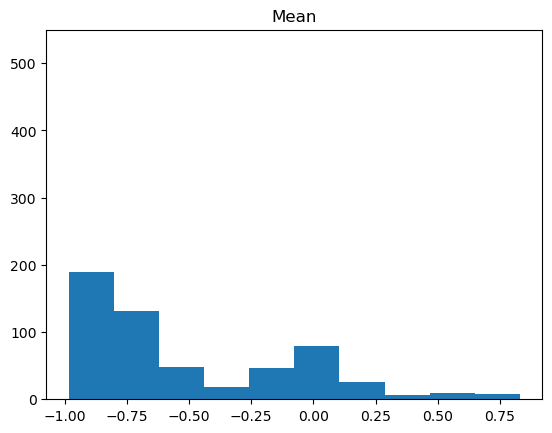

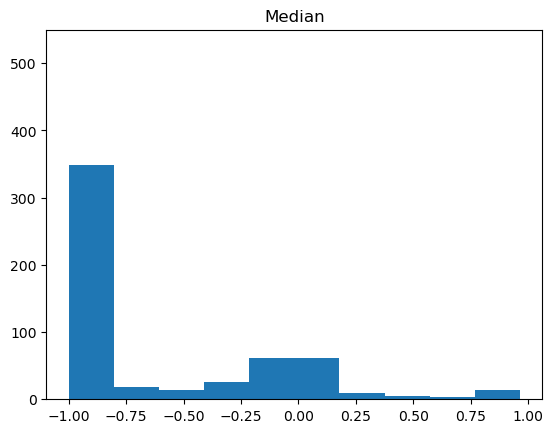

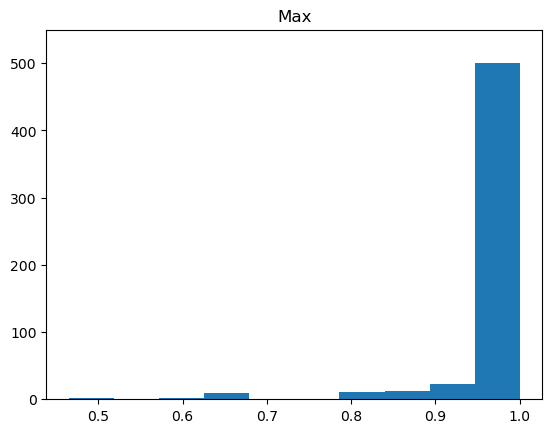

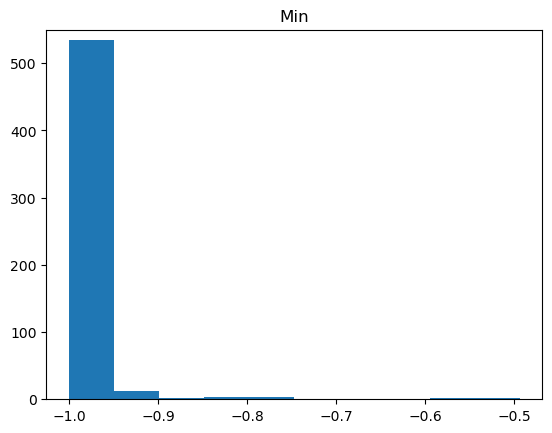

In [11]:
plt.hist(np.mean(data.X_train, axis = 0))
plt.title('Mean')
plt.ylim([0,550])
plt.show()
plt.title('Median')
plt.hist(np.median(data.X_train, axis = 0))
plt.ylim([0,550])
plt.show()
plt.title('Max')
plt.hist(np.max(data.X_train, axis = 0))
plt.ylim([0,550])
plt.show()
plt.title('Min')
plt.hist(np.min(data.X_train, axis = 0))
plt.ylim([0,550])
plt.show()


With so many features, I suspected that there would be lots of correlation between the features. Because of this, the next thing that I did was created a correlation heat map of the data. Since, there are 561 features, I was not able to plot labels on the maps, but I wanted to see in visual format how much correlation there was in the dataset. Looking at the dataset, I noticed that there was significant correlation in the data set.

Also, 561 features is can be significantly add to the computation time between the model used. So between the excess features, and the high correlation amongst some of the features, I decided to employ a feature reduction technique.

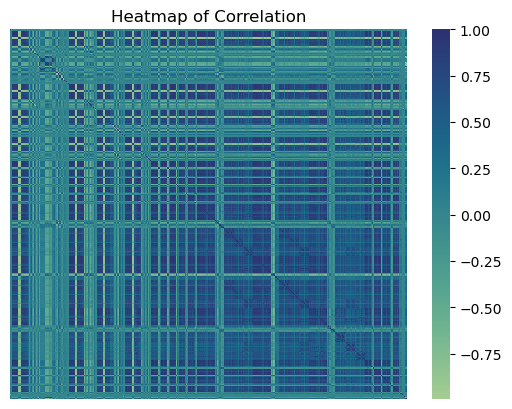

In [12]:
# Create a heatmap with feature correlation
X_corr = data.X_train.corr()
heatmap(X_corr, 
        xticklabels = False, 
        yticklabels = False,
        cmap = 'crest')
plt.title('Heatmap of Correlation')
plt.show()

## Feature Reduction

The feature reduction technique that I decided to use was PCA. I created a chart that showed how much variance was explained by using PCA. We could get .99 percent of the explained variance from just 154 features. That is a reduction in 407 features! 154 features is the number of features that I decided that I would start with. I also did a correlation map after performing PCA, and, as expected, the problem with correlation was corrected by using PCA.

|Explained Variance|Number of Features|
|--------|--------|
|1.00|541|
|.99| 154|
|.98|120|

In [13]:
# Create the PCA Model
data.pca()

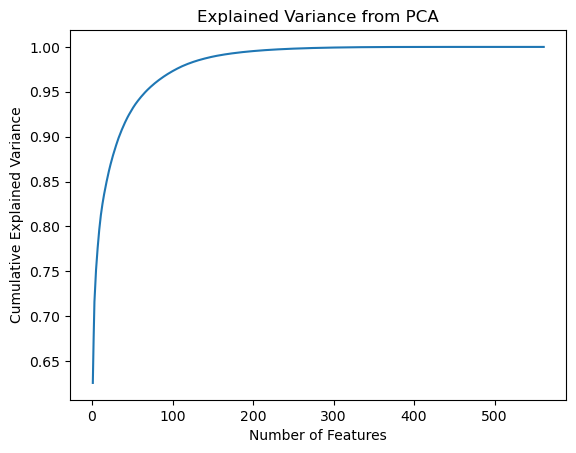

Number of Features for 99 percent: 154
Number of Features for 98 percent: 115


In [14]:
explained_varience = np.cumsum(data.pca_model.explained_variance_ratio_)
x_labels = np.arange(1, len(explained_varience)+1)
plt.plot(x_labels, explained_varience)
plt.title('Explained Variance from PCA')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.show()
print(f"Number of Features for 99 percent: {np.searchsorted(explained_varience, .99)}")
print(f"Number of Features for 98 percent: {np.searchsorted(explained_varience, .98)}")

In [15]:
data.pca(154)

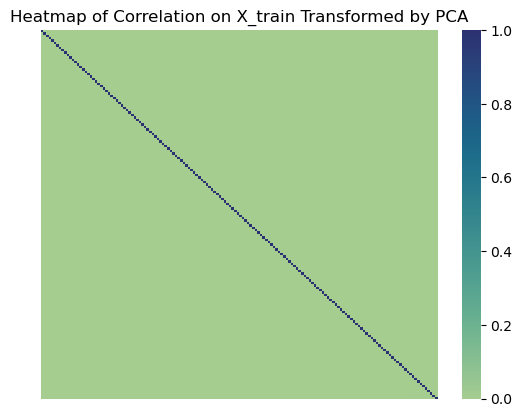

In [16]:
X_pared_corr = pd.DataFrame(data.X_train_pared).corr()
heatmap(X_pared_corr, xticklabels = False, yticklabels = False, cmap = 'crest')
plt.title('Heatmap of Correlation on X_train Transformed by PCA')
plt.show()

# Models

For my unsupervised models, I decided to see how clustering would work. Since there are six "categories," I am going to to cluster with 6 clusters, and see how well the classification works. However, since these models are unsupervised, I am also going to model with other cluster values to see if there is anything else that we can learn from the data. 

## KMeans Clustering

The first model that I used was Kmeans. I started off with an elbow plot for some background on what would be a good cluster size, if we were to not use six. What I discovered was that 6 is not at the elbow. This made me skeptical unto whether we could be able to get good accuracy on classification with this model. There isn't a huge difference between using five, six or seven clusters.

In [17]:
# Elbow chart for number of clusters
inertias = []
number_clusters = np.arange(1,21)

inertias = []
number_clusters = []
for j in range(1,21):
    kmeans_model = KMeans(n_clusters  = j, n_init = 10, algorithm = 'elkan')
    kmeans_model.fit(data.X_train)
    inertias.append(kmeans_model.inertia_)
    number_clusters.append(j)


/home/mharms/anaconda3/envs/machine_learning/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


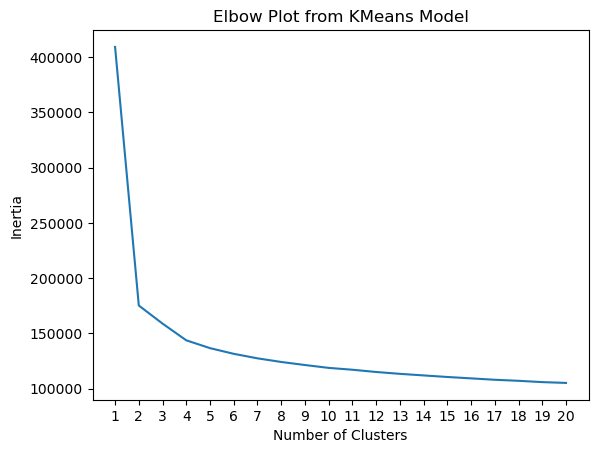

In [18]:
plt.plot(number_clusters, inertias)
plt.title('Elbow Plot from KMeans Model')
plt.xticks(ticks = number_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### Accuracy and Hyperparameter tuning

There are not many hyperparmeters to tune wth Kmeans clustering, however I checked accuracy with all of the parameters. The best accuracy percentage that I was able to achieve was .596. While that is better than guessing, it is not much better. There was no real difference in accuracy from all of the different hyperparameters. Tuning them, did not help much with the accuracy.

In [19]:
kmeans_used_params, kmeans_times, kmeans_acc, kmeans_best_model = try_itterations_kmeans(
    data.X_train_pared, data.y_train, data.X_test_pared, data.y_test)

init = k-means++, algorithm = lloyd, Accuracy = 0.596, Time = 1.463
init = random, algorithm = lloyd, Accuracy = 0.596, Time = 1.306
init = k-means++, algorithm = elkan, Accuracy = 0.595, Time = 1.464
init = random, algorithm = elkan, Accuracy = 0.595, Time = 1.223


In [20]:
# Variables for confusion matrix generation
ypred_kmeans = kmeans_best_model.predict(data.X_test_pared)
label_order_kmeans, kmeans_accuracy = label_permute_compare(data.y_test, ypred_kmeans)
ypred_ordered_kmeans = convert_to_labels(ypred_kmeans, label_order_kmeans)

print(f"Accuracy = {kmeans_accuracy: .3f}")


Accuracy =  0.596


## Hierarchical Clustering

After poor performance of kmeans clustering, I moved on to a hierarchical clustering model. I plotted a dendrogram of the model, and had many of the same concerns that I had with the kmeans model, as far as the ability to get accurate classification. 

In [21]:
hier_model = AgglomerativeClustering(distance_threshold=None, n_clusters=6, compute_distances = True)
hier_model = hier_model.fit(data.X_train_pared)

In [22]:
# Get distance of clusters
hier_model.distances_[7351-6]

82.99634112579592

10.562595844268799


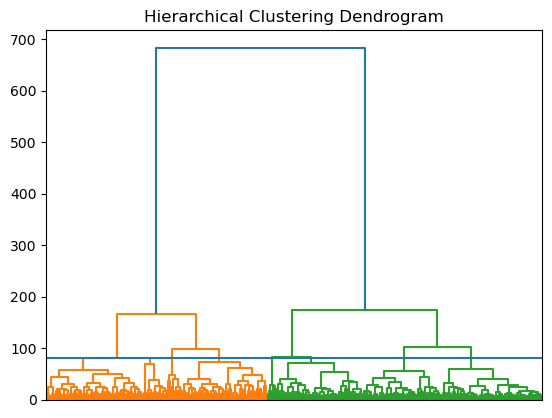

In [23]:
plot_dendrogram(hier_model, labels = None)
plt.axhline(80)
plt.title("Hierarchical Clustering Dendrogram")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

### Accuracy and Hyperparameter tuning

There were a lot more hyperparameters to tune for hierarchical clustering. For that, I created a function that would check all of the possible combinations. I also did not have very good accuracy with this model. The best accuracy that I was able to achieve was .596. Once again, This was barely above random guessing. It was certainly not a ringing endorsement for the model. There is really no situation where this model would be helpful, in a classification capacity.

In [24]:
# Check heierachical clustering with the matrix transformed by PCA
hc_used_params_pared, hc_times_pared, hc_acc_pared, hc_best_model_pared = try_itterations_hierachical_cluster(data.X_test_pared, data.y_test)

Metric = euclidean, Linkage = ward, Accuracy = 0.596, Time = 1.257
here
Metric = euclidean, Linkage = average, Accuracy = 0.359, Time = 1.176
Metric = l1, Linkage = average, Accuracy = 0.185, Time = 1.198
Metric = l2, Linkage = average, Accuracy = 0.359, Time = 1.186
Metric = manhattan, Linkage = average, Accuracy = 0.185, Time = 1.283
Metric = cosine, Linkage = average, Accuracy = 0.359, Time = 1.106
Metric = euclidean, Linkage = complete, Accuracy = 0.448, Time = 1.173
Metric = l1, Linkage = complete, Accuracy = 0.452, Time = 1.189
Metric = l2, Linkage = complete, Accuracy = 0.448, Time = 1.180
Metric = manhattan, Linkage = complete, Accuracy = 0.452, Time = 1.184
Metric = cosine, Linkage = complete, Accuracy = 0.440, Time = 1.115


In [25]:
# Variables for confusion matrix generation
y_pred_hc = hc_best_model_pared.labels_
label_order_hc, hc_accuracy = label_permute_compare(data.y_test, y_pred_hc)
ypred_ordered_hc = convert_to_labels(y_pred_hc, label_order_hc)


## KNN


 In the interest of completeness, I also decided to try and supervised model. I did some hyperparameter tuning. In this case, I just tried to figure out what the best parameter for number of neighbors was. I checked 1 through 15 neighbors, and at about 5 neighbors, the accuracy levels out. There are a few neighbors that had slightly better accuracy. However, I would not use them as there is a small increase in computation time as clusters are added.

Just for comparison purposes, I also tested this model with the data transformed by PCA and the data NOT transformed by PCA. I did this to compare both accuracy and the execution time. 
 
KNN clustering did much better than either of the supervised models. That certainly makes sense, as it is supervised learning, and a supervised model should do better than an unsupervised model. It would depend on the specific use case as to whether this accuracy would be enough from the model.

In [26]:
knn_used_params_pared, knn_times_pared, knn_acc_pared, knn_best_model_pared = try_itterations_knn(
    data.X_train_pared, data.y_train, data.X_test_pared, data.y_test)

n_neighbors = 1, algorithm = auto, Accuracy = 0.879, Time = 0.960
n_neighbors = 2, algorithm = auto, Accuracy = 0.867, Time = 0.869
n_neighbors = 3, algorithm = auto, Accuracy = 0.894, Time = 0.862
n_neighbors = 4, algorithm = auto, Accuracy = 0.894, Time = 0.867
n_neighbors = 5, algorithm = auto, Accuracy = 0.901, Time = 0.856
n_neighbors = 6, algorithm = auto, Accuracy = 0.900, Time = 0.858
n_neighbors = 7, algorithm = auto, Accuracy = 0.902, Time = 0.869
n_neighbors = 8, algorithm = auto, Accuracy = 0.905, Time = 0.868
n_neighbors = 9, algorithm = auto, Accuracy = 0.904, Time = 0.868
n_neighbors = 10, algorithm = auto, Accuracy = 0.905, Time = 0.870
n_neighbors = 11, algorithm = auto, Accuracy = 0.904, Time = 0.868
n_neighbors = 12, algorithm = auto, Accuracy = 0.904, Time = 0.867
n_neighbors = 13, algorithm = auto, Accuracy = 0.904, Time = 0.871
n_neighbors = 14, algorithm = auto, Accuracy = 0.906, Time = 0.873
n_neighbors = 15, algorithm = auto, Accuracy = 0.902, Time = 0.870


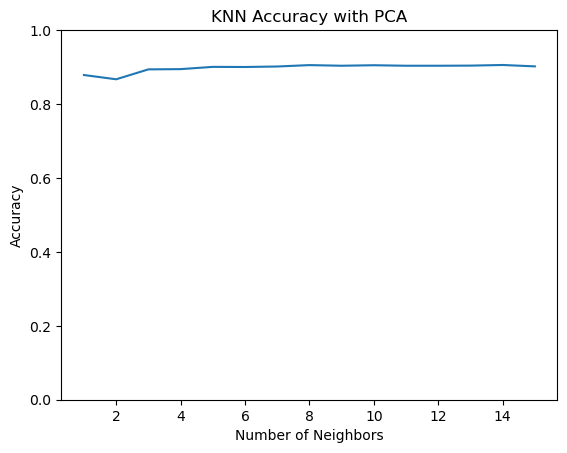

In [39]:
x_values = np.arange(1,16)
plt.plot(x_values, knn_acc_pared)
plt.title('KNN Accuracy with PCA')
plt.ylim([0,1])
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [27]:
knn_used_params_non_pared, knn_times_non_pared, knn_acc_non_pared, knn_best_model_non_pared = try_itterations_knn(
    data.X_train, data.y_train, data.X_test, data.y_test)

n_neighbors = 1, algorithm = auto, Accuracy = 0.879, Time = 1.299
n_neighbors = 2, algorithm = auto, Accuracy = 0.866, Time = 1.293
n_neighbors = 3, algorithm = auto, Accuracy = 0.891, Time = 1.305
n_neighbors = 4, algorithm = auto, Accuracy = 0.893, Time = 1.315
n_neighbors = 5, algorithm = auto, Accuracy = 0.900, Time = 1.289
n_neighbors = 6, algorithm = auto, Accuracy = 0.902, Time = 1.284
n_neighbors = 7, algorithm = auto, Accuracy = 0.902, Time = 1.269
n_neighbors = 8, algorithm = auto, Accuracy = 0.906, Time = 1.298
n_neighbors = 9, algorithm = auto, Accuracy = 0.905, Time = 1.311
n_neighbors = 10, algorithm = auto, Accuracy = 0.907, Time = 1.319
n_neighbors = 11, algorithm = auto, Accuracy = 0.904, Time = 1.311
n_neighbors = 12, algorithm = auto, Accuracy = 0.903, Time = 1.287
n_neighbors = 13, algorithm = auto, Accuracy = 0.906, Time = 1.298
n_neighbors = 14, algorithm = auto, Accuracy = 0.905, Time = 1.304
n_neighbors = 15, algorithm = auto, Accuracy = 0.905, Time = 1.296


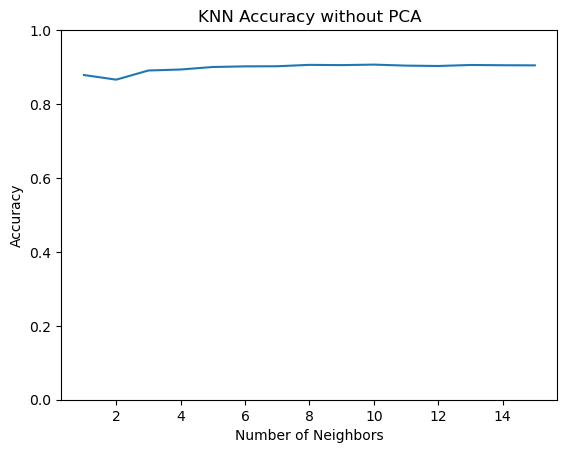

In [41]:
x_values = np.arange(1,16)
plt.plot(x_values, knn_acc_non_pared)
plt.title('KNN Accuracy without PCA')
plt.ylim([0,1])
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [28]:
# Variables for confusion matrix generation
y_pred_knn = knn_best_model_pared.predict(data.X_test_pared)
label_order_knn, knn_accuracy = label_permute_compare(data.y_test, y_pred_knn)
ypred_ordered_knn = convert_to_labels(y_pred_knn, label_order_knn)


# Model Analysis and Evaluation

## Model Comparison


As one can see by looking at the data, neither of the unsupervised learning models did well at all. Their performance was awful. Neither clustering method was to get a result that was much above guessing. While this did help us see some patterns in the data, and helped show how much difference there was between the different activities, for classification, both models are unusable for any kind of classification setting.

The supervised model, did significantly better than those models, with a .906 accuracy rating. It would once again depend on the specific use case of the model to determine if this model would actually be useful or not. 

These results do not surprise me, especially after looking at the elbow plot. After four clusters, there wasn't a huge reduction in inertia, so I am not surprised that the unsupervised algorithms struggled to adequately classify the activities correctly, at six clusters. 

[0.5958601968103155, 0.5961995249406176, 0.9056667797760435]


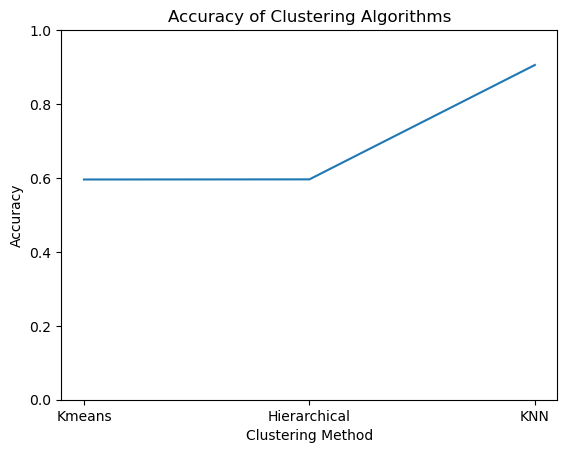

In [29]:
print([max(kmeans_acc),max(hc_acc_pared),max(knn_acc_pared)])
x_plot = ['Kmeans','Hierarchical','KNN']
y_plot = [max(kmeans_acc),max(hc_acc_pared),max(knn_acc_pared)]
plt.plot(x_plot, y_plot)
plt.ylim([0,1])
plt.title('Accuracy of Clustering Algorithms')
plt.xlabel('Clustering Method')
plt.ylabel('Accuracy')
plt.show()

I wanted to get more information about where the algorithms were struggling. To do that, I created confusion matrices of all three models. What those showed was the the both unsupervised models were very deficient in their ability to differentiate any kind of walking, as there were three different types of walking that were classified. and also struggled to differentiate sitting and standing. The supervised learning method did a much better job in this regard. However, the accuracy problems that it did have were associated with these same areas.

These confusion plots confirm some of the information that we gathered from the elbow plot when we first began to model the data. Four clusters looked like a good number of clusters from this data, and if we combined all of the "walking" clusters into one cluster, the accuracy would improve dramatically. This would be at the expense of granularity of classification. 

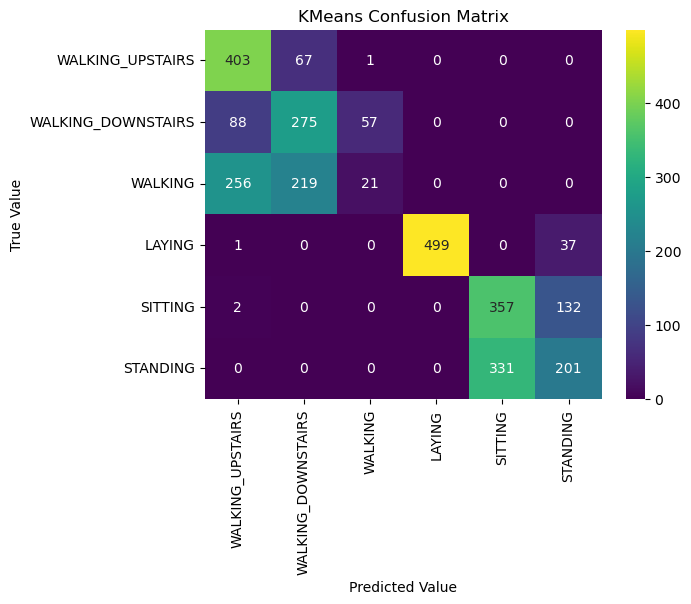

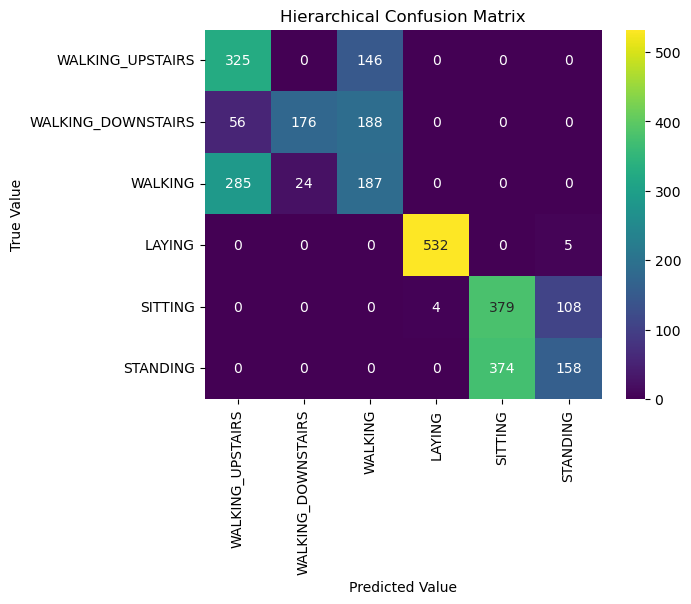

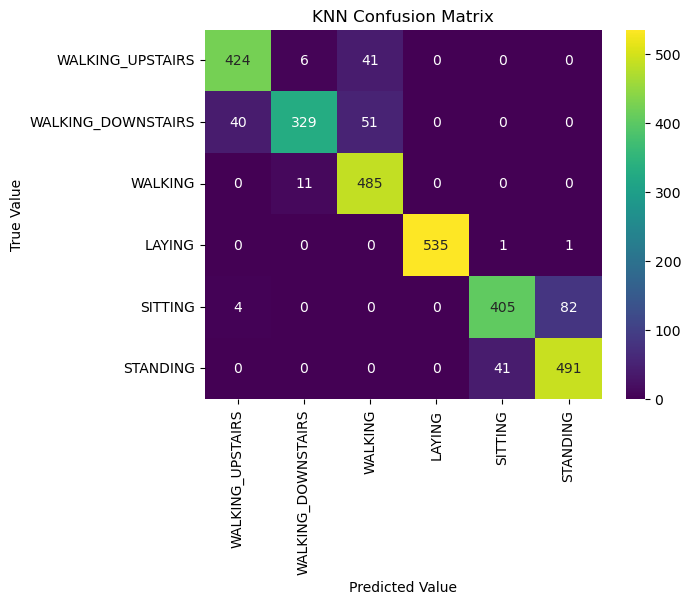

In [30]:
#Plot confusion matricies of all three models

plot_confusion_matrix(
    data.y_test, 
    ypred_ordered_kmeans, 
    labels=label_order_kmeans,
    title = 'KMeans Confusion Matrix')

plot_confusion_matrix(
    data.y_test, 
    ypred_ordered_hc,
    labels=label_order_hc,
    title = 'Hierarchical Confusion Matrix')

plot_confusion_matrix(
    data.y_test, 
    ypred_ordered_knn, 
    labels=label_order_knn,
    title = 'KNN Confusion Matrix')



## PCA Evaluation

While, our models failed to do well when it comes to classification, PCA did work extremely well. I While for this dataset size, PCA was not absolutely necessary, it did significantly reduce the amount of time required to perform, while sacrificing almost nothing in accuracy. PCA reduced the amount of features to only 27 percent of the original features. 

If this calculation needed to be done in an expedient manner, such as an app needing to make a quick decision about the type of accuracy. The features could be reduced to allow the activity to be classified faster.

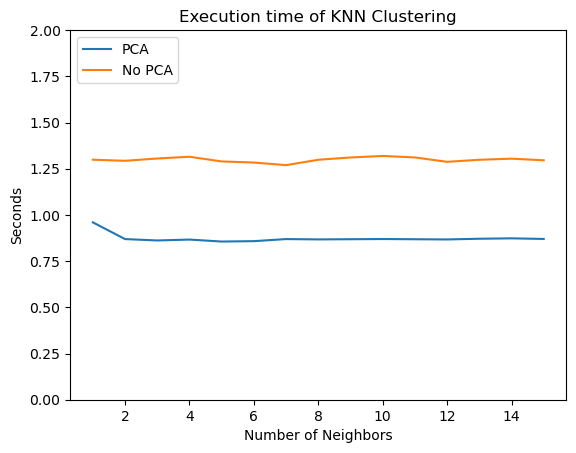

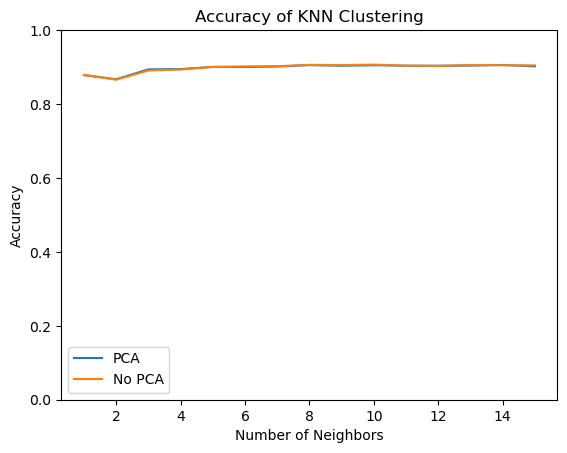

In [43]:
# Plot of 
x_plot = np.arange(1,16)
plt.plot(x_plot, knn_times_pared)
plt.plot(x_plot, knn_times_non_pared)
plt.legend(['PCA','No PCA'], loc='upper left')
plt.ylim([0,2])
plt.title('Execution time of KNN Clustering')
plt.ylabel('Seconds')
plt.xlabel('Number of Neighbors')
plt.show()

x_plot = np.arange(1,16)
plt.plot(x_plot, knn_acc_pared)
plt.plot(x_plot, knn_acc_non_pared)
plt.legend(['PCA','No PCA'])
plt.title('Accuracy of KNN Clustering')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylim([0,1])
plt.show()

## Improvments

There are some ways that these models could be improved. In general, if you are classifying movement, you would have more than one data point. This model could be improved by taking that into account, and looking at other points nearby in time. That could possibly allow a more accurate classification, since people are usually doing the same activity for more than a split second.

As eluded to earlier, another possible improvement would be to reduce the number of clusters, and combine some of the categories that the models struggled with. However, this would be at the expense of granularity, and whether this was acceptable or not, would certainly depend on the ultimate purpose of the model.

Also, more models could also be tried. KNN clustering, while possibly adequate depending on the application, was certainly not perfect. There are many other supervised models that could be tried, that could possibly do better that KNN.

# Conclusion

In this application of classifying activity from the data obtained from smartphone sensors, unsupervised clustering did not do a good job. However, the supervised model did significantly better, but still had room for improvement. While the cluster modeling did not have positive results, reducing the features with PCA did show success, and significantly reduced computation time, without sacrificing accuracy. 

# Citation
Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.
https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

Downloaded from:
https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones